# Feature Engineering Demo (qbt)

This notebook demonstrates core functions from `qbt.features`:
- `momentum`
- `realized_vol`
- `ts_zscore`
- **`cs_zscore` (added here alongside)** – cross‑sectional normalization at each date.

It loads actual price data from CSV files in `/data/raw` directory (AAPL, MSFT, TSLA). If these files are unavailable, it generates synthetic price series so the examples still run.

In [3]:
# Setup: import qbt package and pandas/matplotlib
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Try common repo layouts so the notebook works whether placed in notebooks/ or run standalone
candidate_src_paths = [
    '../src',        # typical when this notebook lives in repo/notebooks/
    './src',         # if run from repo root
    '/workspace/src' # devcontainer style
]
for p in candidate_src_paths:
    if os.path.isdir(p) and p not in sys.path:
        sys.path.append(p)

try:
    from qbt import data
    from qbt import features as F
    print('Imported qbt.data and qbt.features successfully.')
except Exception as e:
    print('Could not import qbt modules. Please ensure ../src is on sys.path and qbt is installed.')
    raise

Imported qbt.data and qbt.features successfully.


In [4]:
# Load close prices from actual CSV files in data/raw
def _load_or_synthesize_prices():
    # Load individual CSV files from data/raw directory
    csv_files = [
        '../data/raw/AAPL.csv',
        '../data/raw/MSFT.csv', 
        '../data/raw/TSLA.csv'
    ]
    
    all_data = []
    loaded_files = []
    
    for csv_path in csv_files:
        try:
            # Load single ticker CSV - the files are already in long format but let's use the proper loader
            prices_long = data.load_prices_long_csv(csv_path, dayfirst=True)  # CSV dates appear to be dd/mm/yyyy
            all_data.append(prices_long)
            loaded_files.append(csv_path)
            print(f'Loaded data from {csv_path}')
        except FileNotFoundError:
            print(f'File not found: {csv_path}')
            continue
        except Exception as e:
            print(f'Failed to load {csv_path}: {e}')
            continue
    
    if all_data:
        # Combine all loaded data
        combined_long = pd.concat(all_data, ignore_index=True)
        close = data.pivot_close(combined_long)
        print(f'Successfully combined data from {len(loaded_files)} files: {[f.split("/")[-1] for f in loaded_files]}')
        print(f'Date range: {close.index.min()} to {close.index.max()}')
        print(f'Tickers: {list(close.columns)}')
        return close
    
    # Fallback: synthesize a small closed-form GBM-like dataset if no real data available
    print('No CSV files found. Generating synthetic price series...')
    rng = np.random.default_rng(42)
    dates = pd.bdate_range('2022-01-03', periods=260)
    tickers = ['AAPL','MSFT','AMZN','GOOG']
    close = pd.DataFrame(index=dates, columns=tickers, dtype=float)
    for t in tickers:
        mu = rng.normal(0.0003, 0.0001)
        sigma = rng.uniform(0.01, 0.025)
        shocks = rng.normal(mu, sigma, size=len(dates))
        prices = 100 * np.exp(np.cumsum(shocks))
        close[t] = prices
    return close

close = _load_or_synthesize_prices()
assert isinstance(close, pd.DataFrame)
print(close.shape)
close.head()

Loaded data from ../data/raw/AAPL.csv
Loaded data from ../data/raw/MSFT.csv
Loaded data from ../data/raw/TSLA.csv
Successfully combined data from 3 files: ['AAPL.csv', 'MSFT.csv', 'TSLA.csv']
Date range: 2025-01-02 00:00:00 to 2025-09-12 00:00:00
Tickers: ['AAPL', 'MSFT', 'TSLA']
(174, 3)


ticker,AAPL,MSFT,TSLA
date,,,
2025-01-02,243.85,418.58,379.28
2025-01-03,243.36,423.35,410.44
2025-01-06,245.00,427.85,411.05
2025-01-07,242.21,422.37,394.36
2025-01-08,242.70,424.56,394.94


## Momentum (rolling return)
Example: 20‑day momentum.

In [5]:
mom_20 = F.momentum(close, lookback=20)
mom_20.head()

ticker,AAPL,MSFT,TSLA
date,,,
2025-01-02,NaN,NaN,NaN
2025-01-03,NaN,NaN,NaN
2025-01-06,NaN,NaN,NaN
2025-01-07,NaN,NaN,NaN
2025-01-08,NaN,NaN,NaN


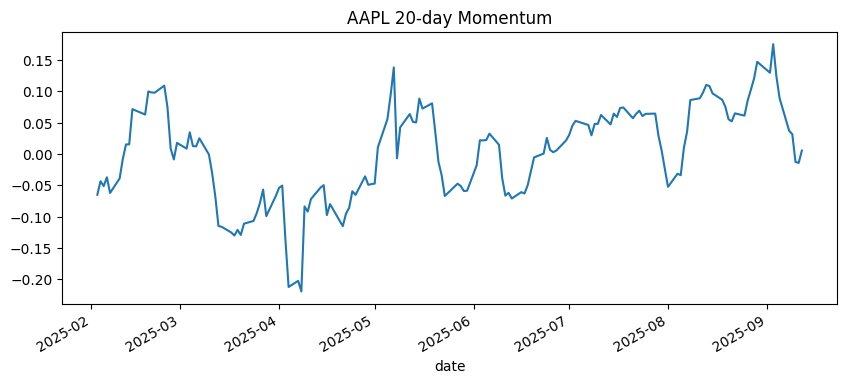

In [6]:
plt.figure(figsize=(10,4))
mom_20.iloc[:,0].plot(title=f"{mom_20.columns[0]} 20-day Momentum")
plt.show()

## Rolling volatility
Example: 20‑day rolling volatility.

In [7]:
vol_20 = F.realized_vol(close, window=20)
vol_20.head()

ticker,AAPL,MSFT,TSLA
date,,,
2025-01-02,NaN,NaN,NaN
2025-01-03,NaN,NaN,NaN
2025-01-06,NaN,NaN,NaN
2025-01-07,NaN,NaN,NaN
2025-01-08,NaN,NaN,NaN


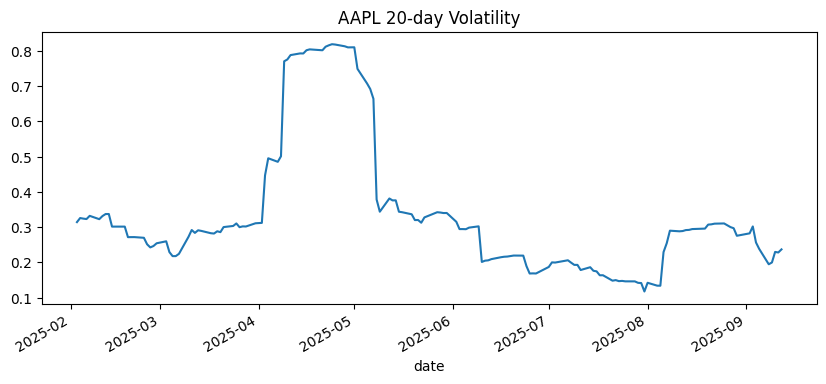

In [8]:
plt.figure(figsize=(10,4))
vol_20.iloc[:,0].plot(title=f"{vol_20.columns[0]} 20-day Volatility")
plt.show()

## Time‑series z‑score (per asset)
Standardize each asset by its own rolling mean/std over a window (e.g., 20 days).

In [9]:
z_20 = F.ts_zscore(close, window=20)
z_20.head()

ticker,AAPL,MSFT,TSLA
date,,,
2025-01-02,NaN,NaN,NaN
2025-01-03,NaN,NaN,NaN
2025-01-06,NaN,NaN,NaN
2025-01-07,NaN,NaN,NaN
2025-01-08,NaN,NaN,NaN


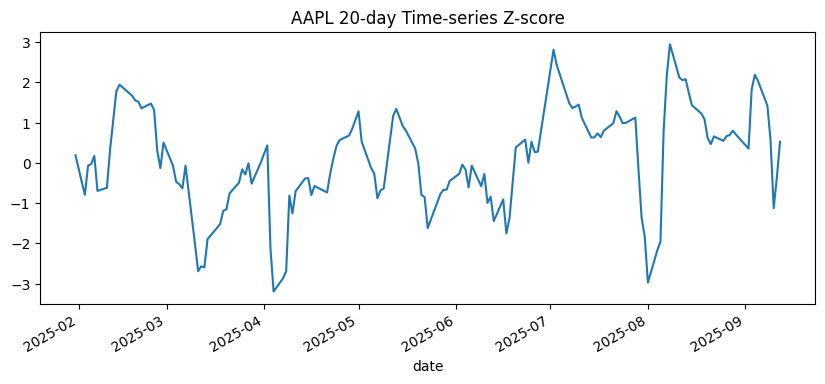

In [10]:
plt.figure(figsize=(10,4))
z_20.iloc[:,0].plot(title=f"{z_20.columns[0]} 20-day Time-series Z-score")
plt.show()

## Cross‑sectional z‑score (added alongside)
At each date, subtract the **cross‑sectional mean across tickers** and divide by the **cross‑sectional std**. This answers:
> *Which assets are high/low relative to their peers **today**?*

You can paste this function into `qbt/features.py`. The cell below will also **define it at runtime** if your local `features.py` doesn't have it yet.

In [11]:
import types
if not hasattr(F, 'cs_zscore'):
    def cs_zscore(df: pd.DataFrame) -> pd.DataFrame:
        """
        Cross-sectional z-score normalization.

        For each date (row), subtract the across-ticker mean and divide by the across-ticker std.

        Parameters
        ----------
        df : pd.DataFrame
            Wide-format: index=dates, columns=tickers.

        Returns
        -------
        pd.DataFrame
            Cross-sectional z-scores with same shape as df.
        """
        mean_row = df.mean(axis=1)
        std_row = df.std(axis=1)
        return df.sub(mean_row, axis=0).div(std_row, axis=0)
    F.cs_zscore = cs_zscore
    print("Defined F.cs_zscore at runtime (please also add it to features.py).")
else:
    print("F.cs_zscore already exists in features.py")

Defined F.cs_zscore at runtime (please also add it to features.py).


In [12]:
xsec_z = F.cs_zscore(close)
xsec_z.head()

ticker,AAPL,MSFT,TSLA
date,,,
2025-01-02,-1.127858,0.778293,0.349565
2025-01-03,-1.152311,0.640450,0.511862
2025-01-06,-1.150706,0.658465,0.492241
2025-01-07,-1.142588,0.715755,0.426833
2025-01-08,-1.141323,0.722439,0.418884


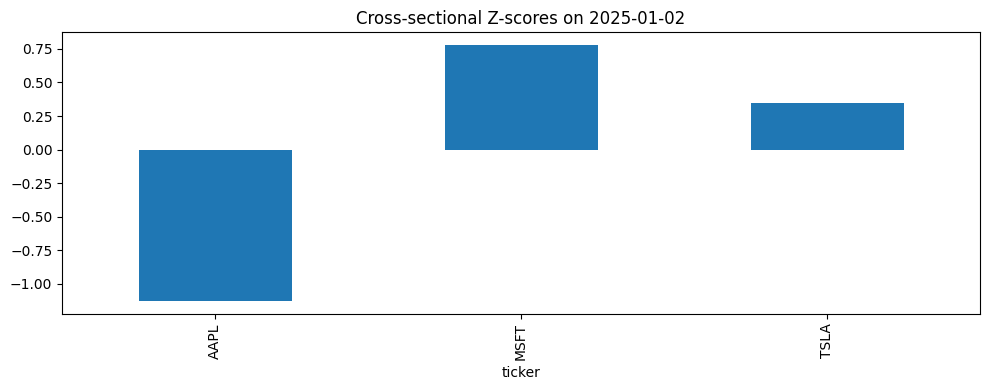

In [13]:
first_good_idx = xsec_z.dropna(how='all').index[0]
plt.figure(figsize=(10,4))
xsec_z.loc[first_good_idx].dropna().plot(kind='bar', title=f"Cross-sectional Z-scores on {first_good_idx.date()}")
plt.tight_layout()
plt.show()

### TL;DR: When to use which z‑score?
- **Time‑series z‑score (`ts_zscore`)**: Compare an asset to *its own history* → good for mean‑reversion or breakout logic per asset.
- **Cross‑sectional z‑score (`cs_zscore`)**: Compare assets *against each other today* → good for ranking/long‑short selection across a universe.